<a href="https://colab.research.google.com/github/hmcgovern/hmcgovern/blob/main/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Set-Up

Installing requirements

In [ ]:
! pip install -r requirements.txt


---

**CODE EXERCISE OUTPUT**

My changes to the data generation process:
- added a few more text patterns 
- use the AutoTokenizer's padding function to pad/truncate all sequences to a length of 10
- additionally save the attention masks to disk for passing to the pretrained language model (necessary because of padding)

More improvements I would make:
- 


In [ ]:
# generate a simple dataset from text patterns.
%run prepare_data.py

comet_ml is installed but `COMET_API_KEY` is not set.


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


INFO:filelock:Lock 140403996860048 acquired on /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.d423bdf2f58dc8b77d5f5d18028d7ae4a72dcfd8f468e81fe979ada957a8c361.lock


INFO:filelock:Lock 140403996860048 released on /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.d423bdf2f58dc8b77d5f5d18028d7ae4a72dcfd8f468e81fe979ada957a8c361.lock


INFO:filelock:Lock 140406823987536 acquired on /root/.cache/huggingface/transformers/0e1bbfda7f63a99bb52e3915dcf10c3c92122b827d92eb2d34ce94ee79ba486c.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99.lock


INFO:filelock:Lock 140406823987536 released on /root/.cache/huggingface/transformers/0e1bbfda7f63a99bb52e3915dcf10c3c92122b827d92eb2d34ce94ee79ba486c.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99.lock


INFO:filelock:Lock 140404031100048 acquired on /root/.cache/huggingface/transformers/75abb59d7a06f4f640158a9bfcde005264e59e8d566781ab1415b139d2e4c603.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4.lock


INFO:filelock:Lock 140404031100048 released on /root/.cache/huggingface/transformers/75abb59d7a06f4f640158a9bfcde005264e59e8d566781ab1415b139d2e4c603.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4.lock


INFO:filelock:Lock 140404031100048 acquired on /root/.cache/huggingface/transformers/8c8624b8ac8aa99c60c912161f8332de003484428c47906d7ff7eb7f73eecdbb.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79.lock


INFO:filelock:Lock 140404031100048 released on /root/.cache/huggingface/transformers/8c8624b8ac8aa99c60c912161f8332de003484428c47906d7ff7eb7f73eecdbb.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79.lock


INFO:__main__:Building a list of simple words associated to ImageNet classes
100%|██████████| 1000/1000 [00:00<00:00, 8727.30it/s]
INFO:__main__:Building a list of sentences associated to each selected ImageNet class
100%|██████████| 598/598 [00:00<00:00, 3683.43it/s]


Importing all necessary packages and setting random seeds for both PyTorch and NumPy to render the models deterministic

In [ ]:
import os

import numpy as np
import torch
import torch.nn as nn
import transformers
from transformers import AutoModel, AutoTokenizer
from pytorch_pretrained_biggan import BigGAN, one_hot_from_int
from mpl_toolkits.axes_grid1 import ImageGrid

from run_model import *

# setting random seeds for reproducibility 
torch.manual_seed(42)
np.random.seed(42)
%matplotlib inline

Loading labels, tokenised sentences, and corresponding attention masks which are the output of [prepare_data.py](./prepare_data.py)

In [ ]:
output_dir='data/'
labels = torch.load(os.path.join(output_dir, 'labels_tensor.bin'))
tokens = torch.load(os.path.join(output_dir, 'tokens_tensor.bin'))
attns = torch.load(os.path.join(output_dir, 'attns_tensor.bin'))
print(labels.shape, tokens.shape, attns.shape)

torch.Size([1794]) torch.Size([1794, 10]) torch.Size([1794, 10])


# 1. Generating BERT Deep-Contextualised Embeddings

Passing the tokens and attention mask through distilBERT forward call

In [ ]:
lm_model = AutoModel.from_pretrained('distilbert-base-uncased')
lm_output = lm_model(input_ids=tokens, attention_mask=attns)
lm_hidden_states = lm_output[0]  # (num_ex, seq_length, hidden_size)
lm_hidden_states.shape

INFO:filelock:Lock 140403890449360 acquired on /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a.lock


INFO:filelock:Lock 140403890449360 released on /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a.lock


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


torch.Size([1794, 10, 768])

# 2. Generating BigGAN Embeddings

Generating BigGAN dense 128-dim vectors from the one-hot class vectors created in [prepare_data.py](prepare_data.py)

In [ ]:
gan_model = BigGAN.from_pretrained('biggan-deep-128');

class_vector = one_hot_from_int(labels, batch_size=labels.size(0))
class_vector = torch.from_numpy(class_vector)
dense_class_vector = gan_model.embeddings(class_vector)
dense_class_vector.shape

# 3. Processing the Data for PyTorch

**CODE EXERCISE OUTPUT**

1. I make a PyTorch dataset class and partition the data in an 80/10/10 (train/validation/test) split.

2. Improvements/alternatives:
  - 


In [ ]:
class MulitModalDataset(torch.utils.data.Dataset):
    # I keep track of both dense and one-hot labels to make visualisation
    #   easier later, but only train using the dense labels
    def __init__(self, hidden_states, dense_labels, class_labels):
        self.hidden_states = hidden_states
        self.hidden_size = hidden_states.size(2)
        # 128-dim GAN hidden state
        self.dense_labels = dense_labels
        # 1000-dim ImageNet one-hot vector
        self.class_labels = class_labels
    
    def __len__(self):
        return self.hidden_states.size(0)
    
    def __getitem__(self, idx):
        return self.hidden_states[idx], self.dense_labels[idx], self.class_labels[idx]

# instantiate a dataset object
data = MulitModalDataset(lm_hidden_states, dense_class_vector, class_vector)

# some hyper-parameters for training 
hp = {
    "sequence_length": 10,
    "input_size": 768,
    "hidden_size": 256,
    "batch_size": 32,
    "num_epochs": 15,
    "learning_rate": 0.001
}

# partitioning the data 80/10/10
total_count = lm_hidden_states.size(0)
train_count = int(0.8*total_count)
valid_count = int(0.1*total_count)
test_count = total_count - train_count - valid_count

train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(data, (train_count, valid_count, test_count))

# creating loader objects to batch the data
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=hp['batch_size'], shuffle=True)  
val_loader  = torch.utils.data.DataLoader(valid_dataset, batch_size=hp['batch_size'], shuffle=False)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=hp['batch_size'], shuffle=False)
dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}

# how many of each data partition?
print([(k, len(dset)) for (k,v),dset in list(zip(dataloaders.items(), [train_dataset, valid_dataset, test_dataset]))])


[('train', 1435), ('val', 179), ('test', 180)]


# 4. Network Architectures


I tested 2 simple mapping models and found them to be effective: 
- **single perceptron model** 
- **multilayer perceptron**


As a first step, I implement a perceptron model: a one-layer neural network used to model linearly separable data. Although usually used in conjunction with a Cross-Entropy Loss for binary classification, if we instead use a MSE loss and don't pass the output through an activation function, we are learning a linear mapping between the input and output spaces. 

Secondly, I wanted to see if performance would improve if I made the network deeper, so I also tested a feed-forward neural network aka a Multilayer Perceptron (MLP). I use ReLU activations to induce non-linearities in the internal (hidden) layer and also used dropout (p=0.5) to deter overfitting. This is still a very shallow NN. 

For both, I use Mean Square Error (MSE) as the loss function because I want the output to be a real-valued vector and not a probability distribution (for which we would pass the output through a sigmoid or softmax).
 

In [ ]:
# model architectures
class Perceptron(nn.Module):
    def __init__(self, input_size, out_size):
        super(Perceptron, self).__init__()
        self.input_size = input_size
        self.linear = nn.Linear(input_size, out_size)
    
    def forward(self, x):
        x = x.reshape(-1, self.input_size)
        x = self.linear(x)
        return x

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, out_size):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.l2 = nn.Linear(hidden_size, out_size)
        
    def forward(self, x):
        x = x.reshape(-1, self.input_size)
        x = self.l1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.l2(x)
        return x

# device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"using: {device}")

using: cuda


## Some Helpers
For visualisation purposes, I create a lookup table correlating the numerical ImageNet class label to a human-readable one from a file I found online [here](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). I can recover the human-readable label (sometimes a list of similar items) using ```get_label_name```.

\\

I create two more utility functions: ```evaluate```, which produces an image from the first example of every batch in the test loader, and ```display```, which plots them as a grid of images with their labels. For a quick project, this serves as a visual check during training to see improvement rather than extensive evaluation metrics.



In [ ]:
label2text = np.load('label2text.npy', allow_pickle=True).flatten()[0]

def get_label_name(idx):
  """Function to return human-readable category label of an ImageNet class.
     Args:
        - idx (int): integer index [0, 999] representing an ImageNet class
     Returns:
        - string representation of ImageNet category label
  """
  return label2text[idx]


def evaluate(model, test_loader, gan_model=None, pretrained_gan_model_name='biggan-deep-128'):
  """Given a mapping model and GAN model, generates a set of images and corresponding labels

     Args:
        - model (nn.Module): PyTorch mapping model
        - test_loader (DataLoader): PyTorch loading object for test set
        - gan_model: a BigGAN model from pytorch_pretrained_biggan library.
            If None a model is instanciated from a pretrained model name given by `pretrained_gan_model_name`
        - pretrained_gan_model_name: shortcut name of the GAN model to instantiate if no gan_model is provided. Default to 'biggan-deep-128'
     Returns:
        - labels (list): list of human-readable string labels for ImageNet classes
        - images (list): list of 128x128 images which are the output of the GAN 
  """

  if gan_model is None:
      gan_model = BigGAN.from_pretrained(pretrained_gan_model_name)

  labels = []
  images = []
  
  # testing loop
  with torch.no_grad():
    for hidden_states, dense_labels, class_labels in test_loader:
      hidden_states, dense_labels = hidden_states.to(device), dense_labels.to(device)

      # forward pass
      outputs = model(hidden_states).to('cpu')
      category = get_label_name(int(torch.argmax(class_labels[0])))
      labels.append(category)
      # using the generate_image fn from run_model.py
      images.append(generate_image(outputs[0], gan_model=gan_model))
  return labels, images


def display(labels, images):
  """Function to display generated test images in a grid with category labels"""
  fig = plt.figure(figsize=(16., 16.))
  grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 4),  # creates 1x4 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

  for ax, label, im in zip(grid, labels, images):
      ax.set_title(label)
      ax.imshow(im)

  plt.show()


# 5. Training
Here's a function to train a model given a model object and some hyperparameters. I use MSE Loss and Adam optimiser. I return the best model at the end of the training process, determined by the lowest validation loss. At the end of each epoch, I display a sample of generated images. 

In [ ]:
def train_model(model, hp, output_name):
  """Main training function.

    Args:
        - model (nn.Module): the model to train
        - hp (dict): a dictionary of hyperparameters for the model
    Returns:
        - best_model (nn.Module):  
  """

  # using Mean Squared Error loss 
  criterion = nn.MSELoss()
  # display images before training (from a newly instantiated model)
  labels, images = evaluate(model, test_loader, gan_model=gan_model)
  print(f"Random Initialisation:")
  display(labels, images)

  optimizer = torch.optim.Adam(model.parameters(), lr=hp['learning_rate'])

  n_total_steps = len(train_loader)
  step = 0
  best_val_loss = 1e4

  for epoch in range(hp['num_epochs']):
    val_loss = 0
      
    # training loop
    for i, (hidden_states, dense_labels, _) in enumerate(train_loader):
        hidden_states, dense_labels = hidden_states.to(device), dense_labels.to(device)

        # forward pass
        outputs = model(hidden_states)
        loss = criterion(outputs, dense_labels)
        
        # backward pass
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        # print to console
        if (i+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{hp["num_epochs"]}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
          
    # validation loop 
    with torch.no_grad():
      
      for i, (hidden_states, dense_labels, _) in enumerate(val_loader):
          hidden_states, dense_labels = hidden_states.to(device), dense_labels.to(device)

          # forward pass
          outputs = model(hidden_states)
          loss = criterion(outputs, dense_labels)
          val_loss += loss.item()

      if val_loss < best_val_loss:
          best_val_loss = val_loss
          print(f"Best validation loss is now: {best_val_loss}")
          best_model = model
          torch.save(best_model, output_name)

    # testing loop
    labels, images = evaluate(model, test_loader, gan_model=gan_model)
    print(f"Epoch: {epoch+1}")
    display(labels, images)



  # return the model with the lowest validation loss
  return best_model



## Perceptron Model

Random Initialisation:


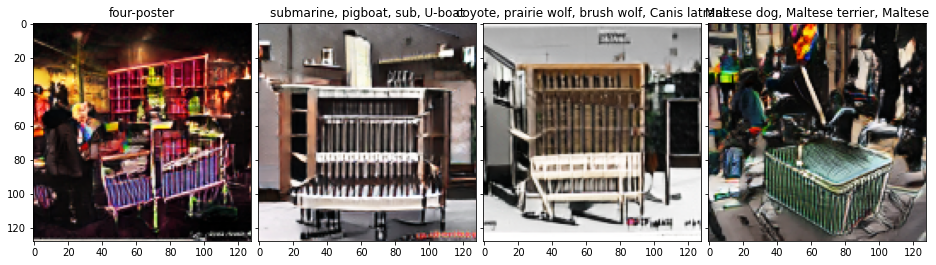

Epoch [1/10], Step [10/30], Loss: 0.5922
Epoch [1/10], Step [20/30], Loss: 0.1717
Epoch [1/10], Step [30/30], Loss: 0.0602
Best validation loss is now: 0.2774820514023304
Epoch: 1


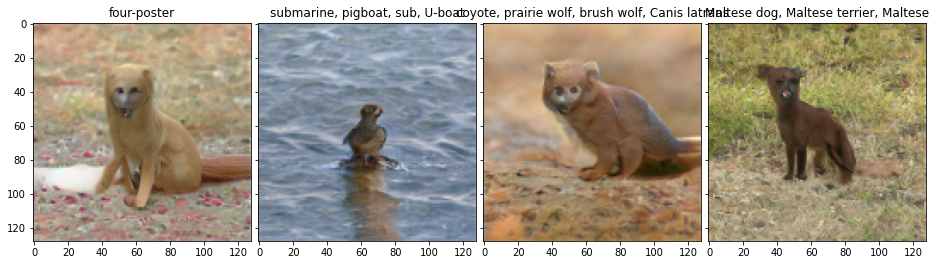

Epoch [2/10], Step [10/30], Loss: 0.0251
Epoch [2/10], Step [20/30], Loss: 0.0198
Epoch [2/10], Step [30/30], Loss: 0.0202
Best validation loss is now: 0.0804049763828516
Epoch: 2


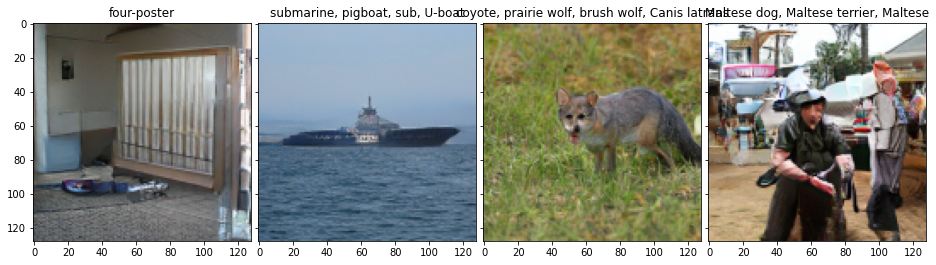

Epoch [3/10], Step [10/30], Loss: 0.0195
Epoch [3/10], Step [20/30], Loss: 0.0140
Epoch [3/10], Step [30/30], Loss: 0.0148
Best validation loss is now: 0.06750562228262424
Epoch: 3


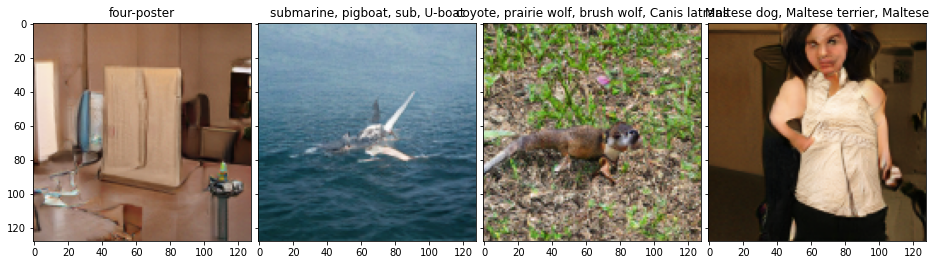

Epoch [4/10], Step [10/30], Loss: 0.0138
Epoch [4/10], Step [20/30], Loss: 0.0240
Epoch [4/10], Step [30/30], Loss: 0.0148
Best validation loss is now: 0.06696191988885403
Epoch: 4


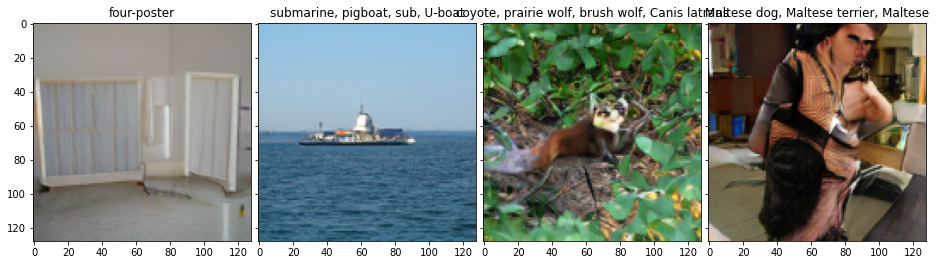

Epoch [5/10], Step [10/30], Loss: 0.0131
Epoch [5/10], Step [20/30], Loss: 0.0176
Epoch [5/10], Step [30/30], Loss: 0.0133
Best validation loss is now: 0.06516135483980179
Epoch: 5


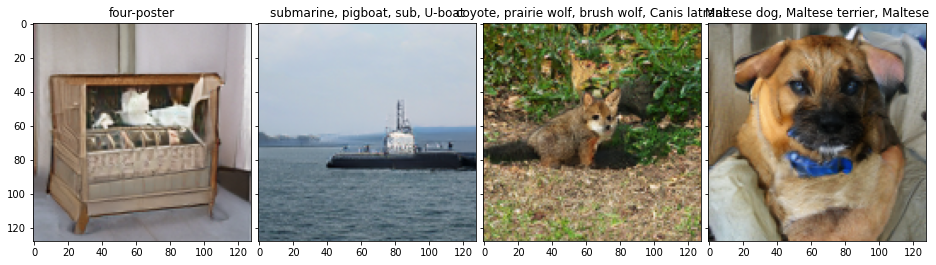

Epoch [6/10], Step [10/30], Loss: 0.0122
Epoch [6/10], Step [20/30], Loss: 0.0128
Epoch [6/10], Step [30/30], Loss: 0.0136
Best validation loss is now: 0.06447883509099483
Epoch: 6


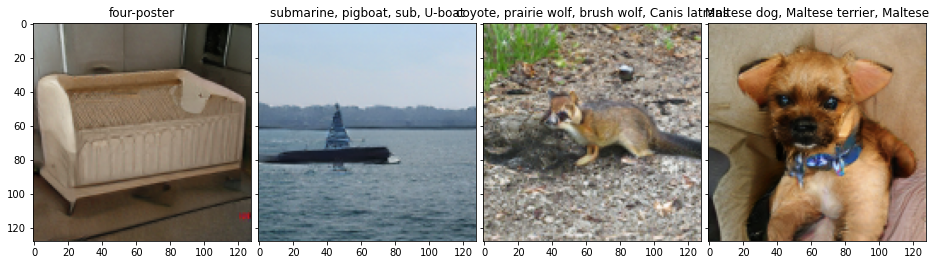

Epoch [7/10], Step [10/30], Loss: 0.0146
Epoch [7/10], Step [20/30], Loss: 0.0117
Epoch [7/10], Step [30/30], Loss: 0.0128
Epoch: 7


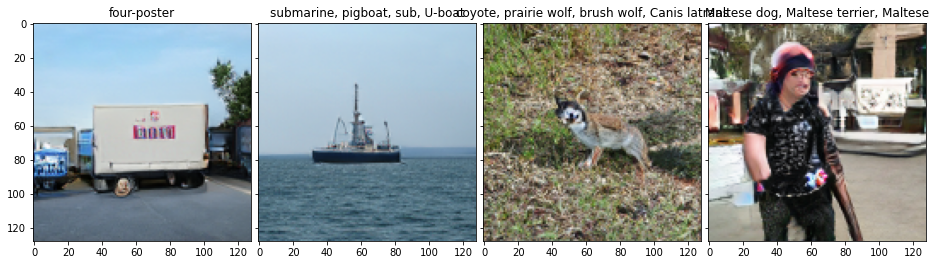

In [ ]:
# instantiate the model
perceptron = Perceptron(hp['sequence_length']*hp['input_size'], dense_class_vector.size(1)).to(device)
# train, saving the best model
best_perceptron_model = train_model(perceptron, hp, 'models/perceptron_model.pt')
# save to disk
torch.save(best_perceptron_model, 'models/perceptron_model.pt')

## MLP Model

In [ ]:
# instantiate the model
mlp = MLP(hp['sequence_length']*hp['input_size'], hp['hidden_size'], dense_class_vector.size(1)).to(device)
# train, saving the best model
best_mlp_model = train_model(mlp, hp)
# save to disk
torch.save(best_mlp_model, 'models/mlp_model.pt')

# Conclusions

On a relatively small dataset, I show that it's possible to learn a mapping function between the 768-dimensional embedding space of BERT deep contextualised embeddings and the 128-dimensional embedding space of BigGAN ImageNet vectors using a simple neural network.

\\

The deeper network (MLP) doesn't seem to do as well as the single-layer perceptron. The larger number of parameters combined with the high-dimensional input vectors (10*768) are probably causing a vanishing/exploding gradient problem. An approach using a Long Short-Term Memory (LSTM) might solve that (see below), as they are more robust to vanishing gradients. 


# Future Work
There are a few other things I would try for a more extensive project:



1. A funkier approach to the problem (which is fundamentally a sequence-to-sequence challenge) would be to treat the embedding spaces as different languages, and use an encoder-decoder network to 'translate' between them.


2. For comparison, I would also have implemented an LSTM sequence classifier that would take a sequence of 768-dim BERT embeddings and classify the sequence as an ImageNet category (aka a 1000-way classification problem). 

  At test time, the model would predict the ImageNet class and then be passed through BigGAN's embedding projection matrix, still providing us with the 128-dense vector to connect the two pre-trained models.

  Given the representational power of BERT embeddings and of LSTMs for sequence classification, this would likely perform quite well and be simpler than learning a mapping between latent spaces directly (just not as cool!).

3. All the usual: more robust evaluation metrics, hyperparameter tuning, more training data...

# Finally, a Demo
Generate a picture from text using the learned mapping function 

In [ ]:
input_text = "i love my cat." #@param {type:"string"}

In [ ]:
model = torch.load('models/perceptron_model.pt')
lm_model = AutoModel.from_pretrained('distilbert-base-uncased')
lm_tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
gan_model = BigGAN.from_pretrained('biggan-deep-128')

# text_to_image fn from run_model.py
img = text_to_image(input_text, mapping_model = model, \
                    lm_model=lm_model, lm_tokenizer=lm_tokenizer,\
                    gan_model=gan_model)
print_image(img)